In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

-----

# Statistische analyse van metingen (constante waarde):

We kunnen een meting als volgt modelleren. Het geen wat we meten $y_{meting}$ bestaat uit de werkelijke waarde $y_{true}$ een systematische fout, ook wel bias genoemd, $e_{bias}$ en een toevallige fout $e_{random}$.

\begin{equation}
y_{meting} = y_{true} + e_{bias} + e_{random}
\end{equation}

Stel onze set metingen bestaan uit een gps posities (gemakshalve zijn enkel x en y waarden genomen (dus 2D ipv 3D), waarbij gemeten werd op 1 en hetzelfde punt ($y_{meas}$) is dus ten alle tijde hetzelfde. 

We kunnen de X posities uitzetten tegen de Y posities en vervolgens de distributie bekijken.

In [3]:
def createMeasurementPicture(numpoints=100,mean=(0,0),std=(3,3)):
    meting = std*np.random.randn(numpoints,2)+mean
    g = sns.jointplot(meting[:,0],meting[:,1],size=10)
    g.set_axis_labels('X-Positie (m)', 'Y-Positie (m)')
    g.ax_joint.plot(0,0,'ro',markersize=20)
    plt.show()
    return meting

<IPython.core.display.Javascript object>


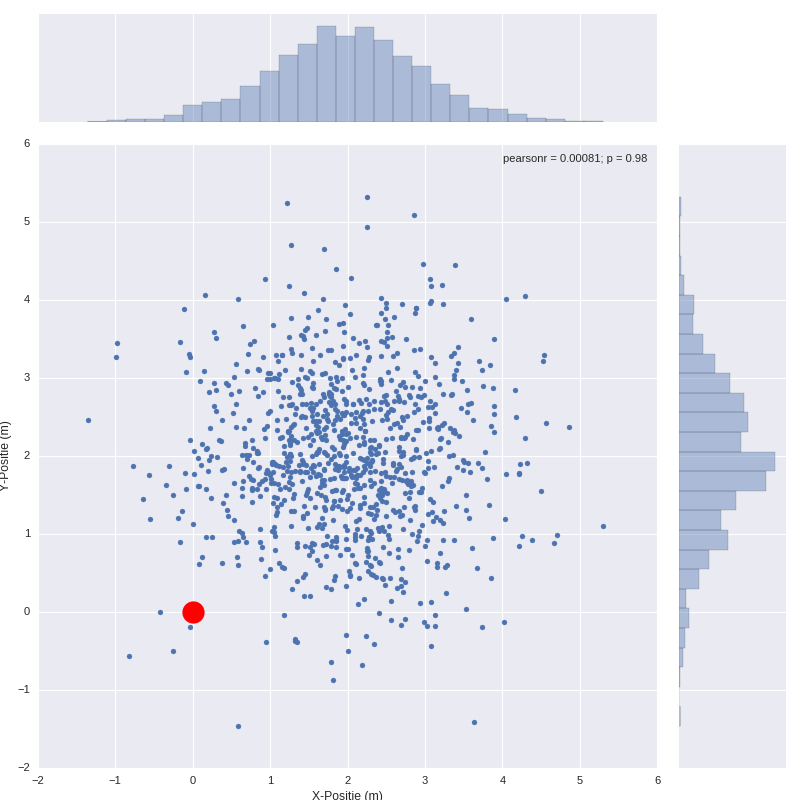

In [4]:
 meting = createMeasurementPicture(numpoints=1000,mean=(2,2),std=(1,1))

Je merkt dat er een zekere spreiding van punten is, waarbij het gemiddelde middelpunt niet overeenkomt met het werkelijke middelpunt.

Indien je de metingen ($x$) als normaal verdeeld kan beschouwen (dit kan je aantonen door heel veel metingen te gaan doen en dan een histogram opstellen) kun je het gemiddelde ($\bar{x}$)en de spreiding (standaard deviatie $\sigma_{x}$ of variantie $\sigma^2_{x}$) als volgt berekenen:

\begin{equation}
\bar{x} = \frac{1}{N} \sum^{N}_{i=1} x_i
\end{equation}


\begin{equation}
\sigma_x^2 = \frac{1}{N} \sum^{N}_{i=1} \left(x_i - \bar{x} \right)^2
\end{equation}


Uiteraard kan je in veel pakkeet ook 1 commando gebruiken om deze waarden uit te rekenen:

In [5]:
print('Het gemiddelden (X en Y): {} m'.format(np.mean(meting,axis=0)))
print('De varianties (X en Y): {} m'.format(np.var(meting,axis=0)))
print('De standaard deviaties (X en Y): {} m'.format(np.std(meting,axis=0)))

Het gemiddelden (X en Y): [ 1.97220582  2.00058344] m
De varianties (X en Y): [ 0.95951904  0.98180996] m
De standaard deviaties (X en Y): [ 0.97955043  0.99086324] m


## Niet normaal verdeelde meting:

Vaak kun je veronderstelling dat deze metingen normaal verdeeld zijn. Ga hier echter niet zo maar vanuit. Bijvoorbeeld een dobbelsteen 100 keer werpen geeft de volgende (uniforme) verdeling:

<IPython.core.display.Javascript object>


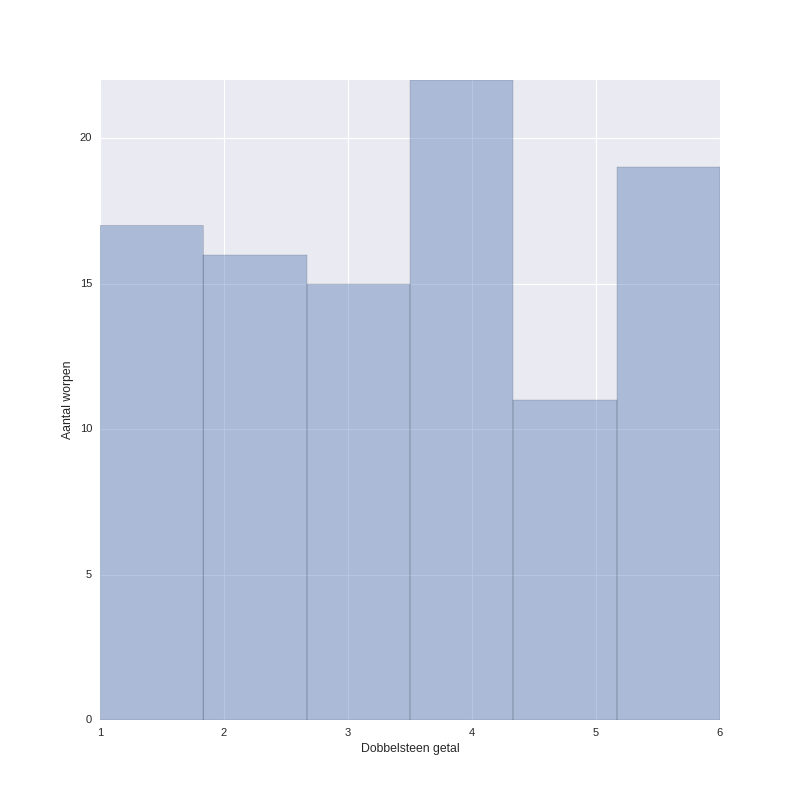

In [6]:
N=100
roll = np.random.randint(1,7,N)
plt.figure(num=None, figsize=(10, 10))#, dpi=120, facecolor='w', edgecolor='k')
sns.distplot(roll,kde=False,bins=6)
#plt.xticks(np.arange(1,7))
plt.xlabel('Dobbelsteen getal')
plt.ylabel('Aantal worpen')
plt.axis('tight')
plt.show()

-----

# Analyse van metingen (lineair verband)


Stel een meting kan als volgt beschreven worden:

\begin{equation}
y_{meas} = A \cdot y_{true} + b + e
\end{equation}

Om $y_{true}$ te vinden moeten we gaan **kalibreren**. Wezenlijk houdt dit in dat we de waarde van $A$ (versterkingsfactor, ofwel 'gain') en de offset $b$ moeten gaan bepalen. De toevallige fout $e$ kunnen we niet weg kalibreren dus die laten we buiten beschouwing. We kunnen de formule als volgt omzetten:

\begin{equation}
y_{true} = A^{-1} \cdot (y_{meas} - b)
\end{equation}

We moeten dus wederom het 'echte' proces weten. Bij het kalibreren ga je dus je metingen altijd vergelijking met de werkelijke waarden. Via de lineaire kleinste kwadraten methode (linear least squares) kunnen we $A$ en $b$ bepalen aan de hand van een set metingen.


Stel we hebben een set metingen gedaan met een (lineaire) temperatuurs gevoelige sensor, die we willen kalibreren zodat we de werkelijke temperatuur (blauw) vinden. Op de *X-As* staat de ingestelde temperatuur (bijvoorbeeld van een oven). Op de *Y-As* staat de gemeten temperatuur (groen) en de werkelijke temperatuur (blauw).

<IPython.core.display.Javascript object>


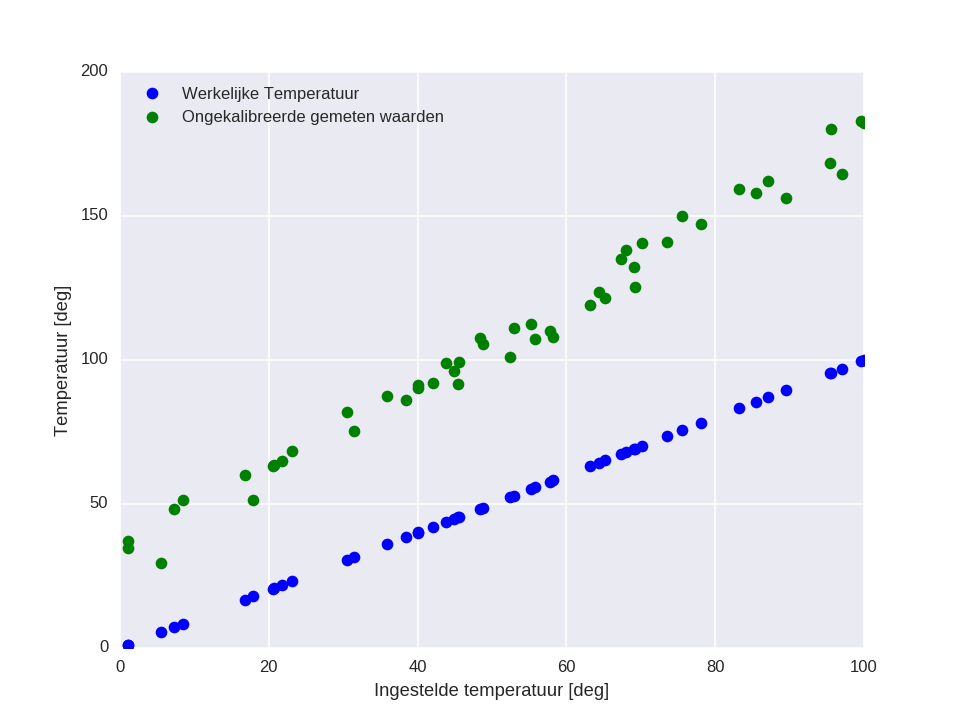

In [7]:
def generateMovingPositionData(A=1.5,b=30,Nmeas=100,variance=5e0):
    xtrue = 100*np.random.rand(Nmeas,1)
    ytrue = xtrue
    ymeas = np.zeros((Nmeas,1))
    
    for i in range(Nmeas):
        ymeas[i] = A*ytrue[i] + b + variance*np.random.randn(1)
    return xtrue,ytrue,ymeas

Nmetingen = 50
plt.figure(num=None, figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k');
xtrue,ytrue,ymeas = generateMovingPositionData(Nmeas=Nmetingen)
plt.plot(xtrue,ytrue,'bo',label='Werkelijke Temperatuur')
plt.plot(xtrue,ymeas,'go',label='Ongekalibreerde gemeten waarden')
plt.xlabel('Ingestelde temperatuur [deg]')
plt.ylabel('Temperatuur [deg]')
plt.legend(loc='upper left')
plt.show()

We zoeken de coefficienten A en b, deze bepalen de (optimale, dus rekening houdend met de ruis) offset en stijlheid (versterking) van bovenstaande groene plot. Wanneer deze bekend zijn kunnen we gaan compenseren (en is de sensor gekalibreerd) en vinden we de werkelijke meting (blauw). 

Zoals eerder verteld kunnen we de meting schrijven als:

$y_{meas} = A \cdot y_{true} + b$ 

Dit kunnen we verder uitschrijven als:

$y_{meas} = M \cdot p$ waarbij:
$M =\left[y_{true} \hspace{0.2cm} 1\right]$ en:
$p = [A \hspace{0.2cm} b]^T$. 

Let op dat de $1$ in $M$ een een vector is met dezelfde lengte als $y$. 
De *vector* $p$ bevat de waarden voor $A$ en $b$ waarin we geintereeseerd zijn.
Om deze $p$ te bepalen schrijven we:

\begin{equation}
p = M^{-1} \cdot y_{meas}
\end{equation}

Vervolgens kunnen de least squares functionaliteit gebruiken van een willekeurig software pakket. Bijvoorbeeld in MatLAB is dit het commando:

    p = M\y_meas

Versterkingsfactor: 1.4616316480352383, offset: 32.02270218562222


<IPython.core.display.Javascript object>


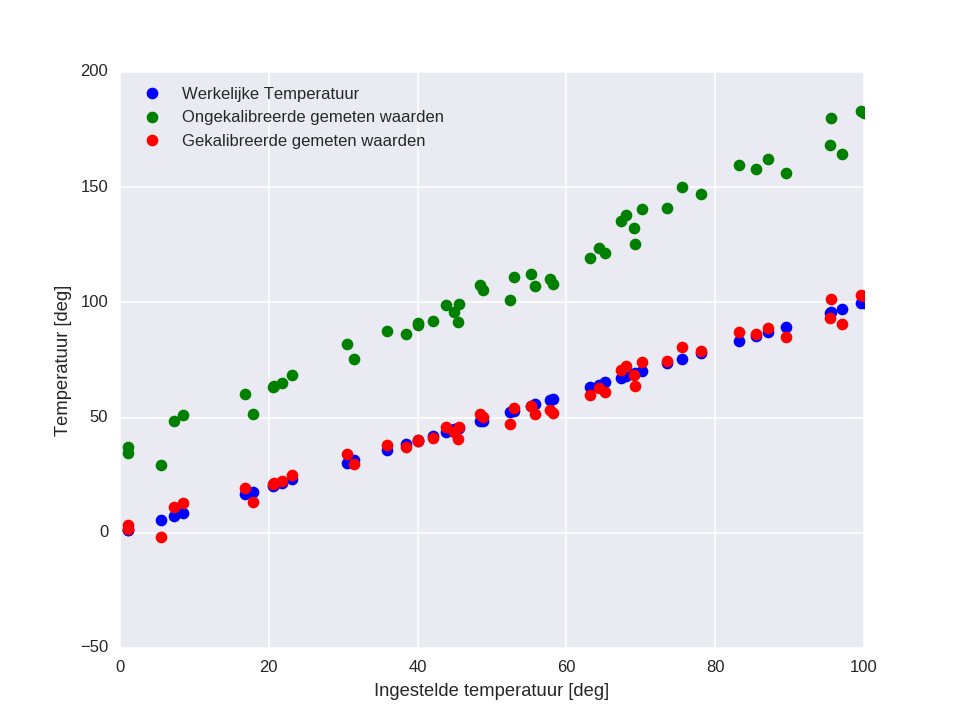

In [8]:
M = np.hstack([ytrue, np.ones((Nmetingen,1))])
A,b = np.linalg.lstsq(M, ymeas)[0]

print('Versterkingsfactor: {}, offset: {}'.format(A[0],b[0]))

plt.figure(num=None, figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k');
plt.plot(xtrue,ytrue,'bo',label='Werkelijke Temperatuur')
plt.plot(xtrue,ymeas,'go',label='Ongekalibreerde gemeten waarden')
plt.plot(xtrue,A**(-1)*(ymeas-b),'ro',label='Gekalibreerde gemeten waarden')
plt.xlabel('Ingestelde temperatuur [deg]')
plt.ylabel('Temperatuur [deg]')
plt.legend(loc='upper left')
plt.show()

Bedenk nu zelf hoe je vervolgens de standaard deviatie van $e$ kunt bepalen.

----
### Niet lineare verbanden (ToDo)
----

------------
## Sampling en Kwantisatie:
------------
Een processor kan alleen wiskundige operaties uitvoeren op digitale signalen, daarvoor zijn twee acties nodig:
![Analog, discrete and digital signals](analog_discrete_digital.png)

---
## Sampling en Aliasing:
---

Stel je voor we gaan twee sinusvormige ingangssignalen met een zekere frequentie van respectievelijk $f_1= 0.3~Hz$ en $f_2= 1.3~Hz$ samplen (of bemonsteren) met een frequentie van $f_s = 1~Hz$:

<IPython.core.display.Javascript object>


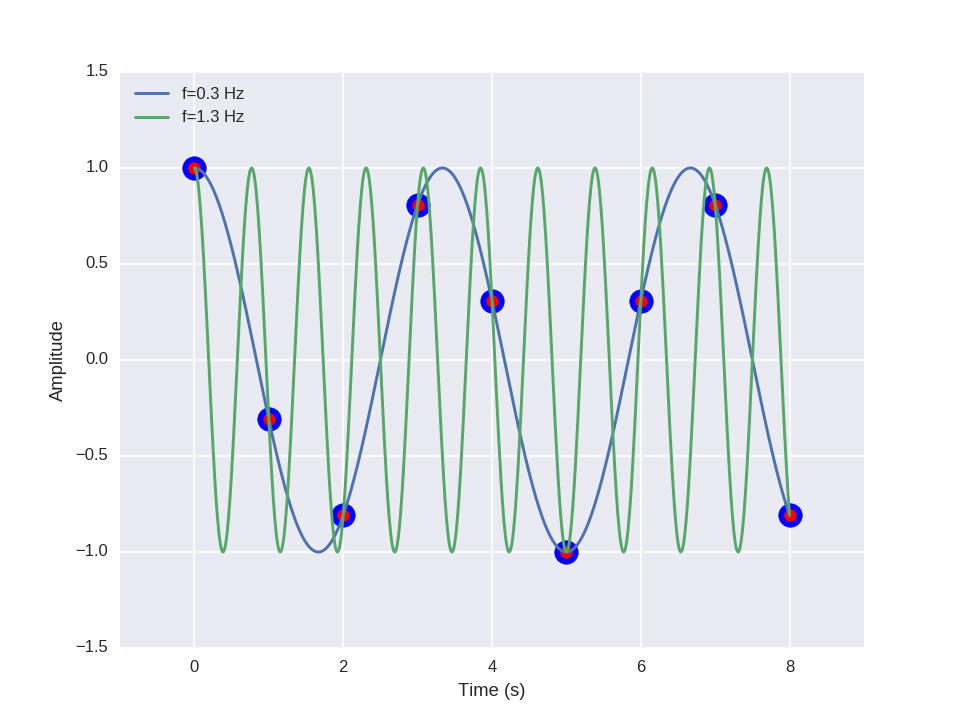

In [9]:
T = 1 #sampling period
t = np.linspace(0,8,801) #for the continuous time signals
n = np.arange(0,9) #discrete time intervals

f1 = 0.3
f2 = 1.3

w1 = 2*np.pi*f1
w2 = 2*np.pi*f2

y1 = np.cos(w1*t)
y2 = np.cos(w2*t)


plt.figure(num=None, figsize=(8,6), dpi=120, facecolor='w', edgecolor='k')
plt.plot(t,y1, label='f=0.3 Hz')
plt.plot(t,y2, label='f=1.3 Hz')
plt.scatter(n,np.cos(w2*n*T),marker='o',color='blue',s=200)
plt.scatter(n,np.cos(w1*n*T),marker='.',color='red',s=200)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper left')

## Conclusie: 

Bij het reconstrueren krijgen beide signalen dezelfde frequentie, terwijl aanvankelijk er een verschil is. 

### Zorg dat je sample frequentie minimaal 2x zo groot is dan de hoogste frequentie die je wilt gaan meten!
-----

## Quantization

Stel we hebben een 3 bits analoog naar digitaal (AD) converter. Wat betekend dit voor de ruis.

Het aantal intervallen (levels) wordt bepaald door het aantal bits (n):

\begin{equation}
levels = 2^{n} = 2^3 = 8
\end{equation}

De resolutie (vaak in Volt uitgedrukt) die vervolgens verkregen wordt:
\begin{equation}
resolutie = \frac{bereik}{levels} = \frac{1 - - 1}{8} = 0.25~V
\end{equation}

<IPython.core.display.Javascript object>


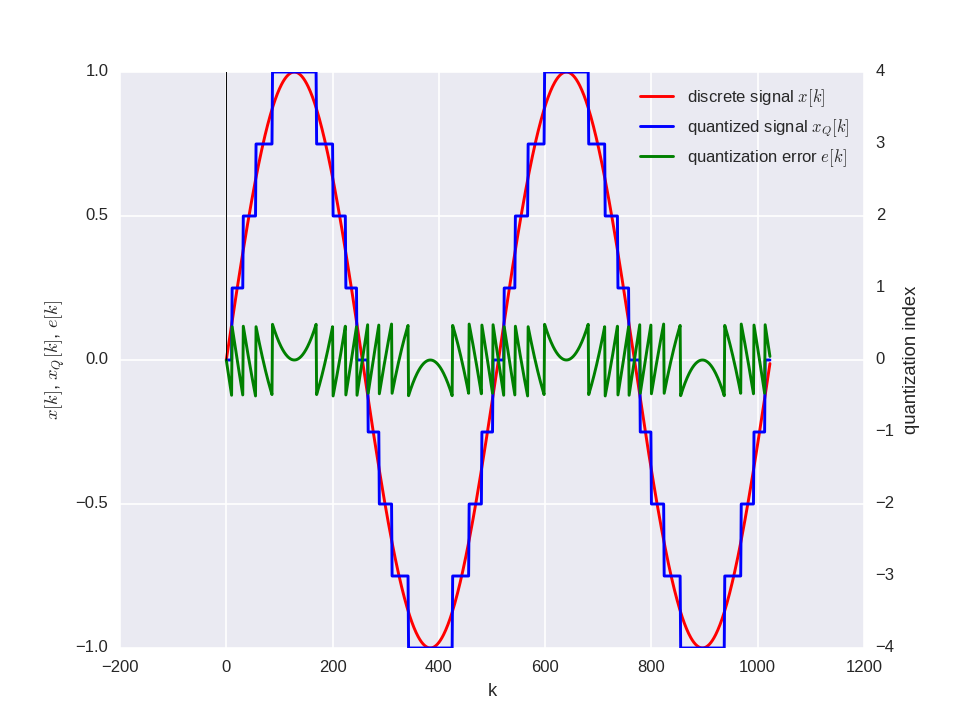

In [10]:
N = 2**10  # length of signal

# generate signal
x = np.sin(4*np.pi/N * np.arange(N))
#x = 1*np.random.randn(N)
# quantize signal
xi = np.round(4 * x)
xQ = 1/4* xi
e = xQ - x

# plot (quantized) signals
fig, ax1 = plt.subplots(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k')
ax2 = ax1.twinx()

ax1.plot(x, 'r', label=r'discrete signal $x[k]$')
ax1.plot(xQ, 'b', label=r'quantized signal $x_Q[k]$')
ax1.plot(e, 'g', label=r'quantization error $e[k]$')
ax1.set_xlabel('k')
ax1.set_ylabel(r'$x[k]$, $x_Q[k]$, $e[k]$')
ax1.legend()

ax2.set_ylim([-4, 4])
ax2.set_ylabel('quantization index')
ax2.grid()
plt.show()

In [11]:
sns.distplot(e,kde=False)
plt.show()

## Signal-to-Noise Ratio (SNR)

De kwaliteit van het kwantiseren kan je uitdrukken door middel van de [signal-to-noise ratio](https://en.wikipedia.org/wiki/Signal-to-noise_ratio) (SNR):

$$ SNR~[dB] = 10 \cdot \log_{10} \left( \frac{\sigma_x^2}{\sigma_e^2} \right)$$

waar $\sigma_x^2$ and $\sigma_e^2$ de varianties van het signaal en ruis inhouden. 

Zonder de berekening te geven kan je er van uit gaan dat de SNR bepaald wordt door:
$$ SNR~[dB] \approx 6.02 \, n + 1.76$$
Waarbij $n$ het aantal bits van de AD converter is. 